### mm_phasereset

This function computes group statistics on phase reset results (within electrode)

1) Is there theta phase-reset at the time of movement?

2) Is there temporal specificity here?

3) Is there frequency specificity?

4) Is there task specificity?


In [1]:
# import packages
import numpy as np # numpy
import pandas as pd # pandas
from scipy import stats
import mm_func
import mne
import pycircstat as circ
from mne import time_frequency
from fooof import FOOOF
from pylab import * 
%matplotlib inline
import os

In [68]:
# set params
# define parameters for analyses as a dictionary
params = {'rejection_thresh_sd':20,
          'event_type':'move',
          'time_window_ms_wave':(-1800,1800),
          'time_window_ms_pre':(-500,-100),
          'time_window_ms_post':(100,500),
          'buffer_ms_wave':1000,
          'frange_wave':(3,120),
          'numfreqs_wave':15,
          'HFA_range':(70,120),
          'theta_range':(3,8),
          'alpha_range':(10,12),
          'beta_range':(12,30),
          'gamma_range':(30,50)} 
# fig path
figpath = '/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/phase_reset/'
print(figpath)

# make directory if it doesnt exist
if os.path.exists(figpath) == False:
    os.makedirs(figpath)
    

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/phase_reset/


In [3]:
# load data
#load data from Cluster 3
[EEG_c3,metadata_c3] = mm_func.loadEEG(clusId=3)

#load data from Cluster 1
[EEG_c1,metadata_c1] = mm_func.loadEEG(clusId=1)


/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-1.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 1 = 38
REPLACING Contact 0 field anat with NONE
REPLACING Contact 1 field anat with NONE
REPLACING Contact 10 field anat with NONE
REPLACING Contact 13 field anat with NONE
REPLACING Contact 31 field anat with NONE
Done loading Cluster 1


In [66]:
class PhaseResetGroup:
    
    def __init__(self,EEG,metadata):

        # label this electrode group
        self.EEG = EEG
        self.metadata = metadata
        
        # initialize containers for function below (format: self.ralz_theta_pre)
        self.ev_lbls = ['wait','inst','move'] # time window lbls
        self.toi_lbls = ['pre','post'] # time window lbls
        self.foi_lbls = ['theta','alpha','beta','gamma','HFA'] # freq of interest lbls
        
        for t in arange(0,len(self.toi_lbls)):
            for f in arange(0,len(self.foi_lbls)):
                for e in arange(0,len(self.ev_lbls)):
                    setattr(self,'ralz_'+self.ev_lbls[e]+'_'+self.foi_lbls[f]+'_'+self.toi_lbls[t],[])
    def append_PLV_local(self,E,event_type,params):
        """This function appends PLV data from an electrode to the containers in self.
        Used in function below
        Inputs: 
        E -instande of electrode class with E.getEEG and E.calcPhase already calculated 
        event_type: move vs. wait vs. inst
        params: needs freq ranges (e.g., ['theta_range']:(3,8) and time_window_pre and post)"""
        
        # loop through time of interes (toi) and freq of interest (foi) labels
        for t in arange(0,len(self.toi_lbls)):
            for f in arange(0,len(self.foi_lbls)):
                
                # for each interation, update the PLV for E using these foi and toi params   
                E.calcPLV(params[self.foi_lbls[f]+'_range'],params['time_window_ms_'+self.toi_lbls[t]])

                # append container array
                # get current array
                x = getattr(self,'ralz_'+event_type+'_'+self.foi_lbls[f]+'_'+self.toi_lbls[t])

                # append new PLV valuew
                x = np.append(x,E.PLV_z)

                #store new array in container
                setattr(self,'ralz_'+event_type+'_'+self.foi_lbls[f]+'_'+self.toi_lbls[t],x)

        
    def collect_raleigh_z(self,params):
        """This function loops through the group of electrodes and collects pertinent phase reset data 
        for various task related events
        
        
        # Inputs
        params - dictionary that must contain the following 
        
        params = {'time_window_ms_wave':(-1800,1800),# time window to run wavelet around each event
        'buffer_ms':1000, # buffer to include when running the wavelet
        'rejection_thresh_sd':20} # threshold to use when rejecting single trials with noisy data
        """
        
        # loop through electrodes
        for c in arange(0,len(self.EEG)):
            
            # instantiate Electrode
            E = mm_func.Electrode(self.EEG[c],self.metadata[c:c+1])
            
            # get eeg clip for move
            event_type = 'move'
            E.getEEG(event_type,params['time_window_ms_wave'], params['buffer_ms_wave'],params['rejection_thresh_sd'])
            
            # calc all_phase (this removes the buffer, dont re-run it unless you get a new eeg clip)
            E.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])
            
            # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
            self.append_PLV_local(E,event_type,params)
            
            
            
            # get eeg clip for inst
            event_type = 'inst'
            E.getEEG(event_type,params['time_window_ms_wave'], params['buffer_ms_wave'],params['rejection_thresh_sd'])
            
            # calc all_phase (this removes the buffer, dont re-run it)
            E.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])
            
            # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
            self.append_PLV_local(E,event_type,params)
            
            
            
            # get eeg clip for wait
            event_type = 'wait'
            E.getEEG(event_type,params['time_window_ms_wave'], params['buffer_ms_wave'],params['rejection_thresh_sd'])
            
            # calc all_phase (this removes the buffer, dont re-run it)
            E.calcPhase(params['buffer_ms_wave'],params['frange_wave'],params['numfreqs_wave'])
            
            # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
            self.append_PLV_local(E,event_type,params)
            
            
        
        # params
        self.time_window_ms_wave = params['time_window_ms_wave']
        self.buffer_ms_wave = params['buffer_ms_wave']
        self.frange_wave = params['frange_wave']
        self.numfreqs_wave = params['numfreqs_wave']
        self.time_window_ms_pre = params['time_window_ms_pre']
        self.time_window_ms_post = params['time_window_ms_post']
        self.theta_range = params['theta_range']
        self.alpha_range = params['alpha_range']
        self.beta_range = params['beta_range']
        self.gamma_range = params['gamma_range']
        self.HFA_range = params['HFA_range']

    def plot_errorbar(self,ax=None,lbl = 'ralz_move_theta_pre',xval=1,kol='blue'):
        """This function plots an error bar of a z-vec
        Inputs:
        xval - marks the x-value to plot the error bar
        kol - color to use"""
        if ax == None:
            fig = figure()
            ax = subplot(111)
        
        z_vec = getattr(self,lbl)
              
        # plot mean and SD of slope pre
        mean_slope = mean(z_vec)
        sem_slope = stats.sem(z_vec)
        errorbar(xval,mean_slope,sem_slope,color = kol)
        
    def plot_errorbar_summary(self,ax=None,foi='theta',thisKol = 'blue'):
        """This function plots a summary of the phase reset z-vecs across 
        various conditions for a frequency band of interst 

        Iputs
        foi = 'theta' (string label of the freq band of interest)"""
        if ax == None:
            fig = figure()
            ax = subplot(111)


        # Make this a stand alone plotting function
        count = 0
        xlbls = []
        for e in arange(0,len(self.ev_lbls)):
            for t in arange(0,len(self.toi_lbls)):
                count+=1
                event_type = self.ev_lbls[e]
                toi = self.toi_lbls[t]

                # plot it
                self.plot_errorbar(ax,lbl = 'ralz_'+event_type+'_'+foi+'_'+toi,xval = count,kol=thisKol)
                
                # update labels
                xlbls.extend([event_type+'-'+toi])
                #print(xlbls)

        # set xticks
        xticks(arange(1,len(xlbls)+1),xlbls,rotation=90)
        ylabel('Raleigh z (mean +/- sem)')
        ax.set_title('Cluster '+ str(self.metadata[0:0+1].clusId[0])+' '+foi)


In [67]:
%%capture
#pilot analyses

# initialize cluster 3
C3 = PhaseResetGroup(EEG_c3,metadata_c3)

# collect raleigh stats
C3.collect_raleigh_z(params)

# initialize cluster 3
C1 = PhaseResetGroup(EEG_c1,metadata_c1)

# collect raleigh stats
C1.collect_raleigh_z(params)


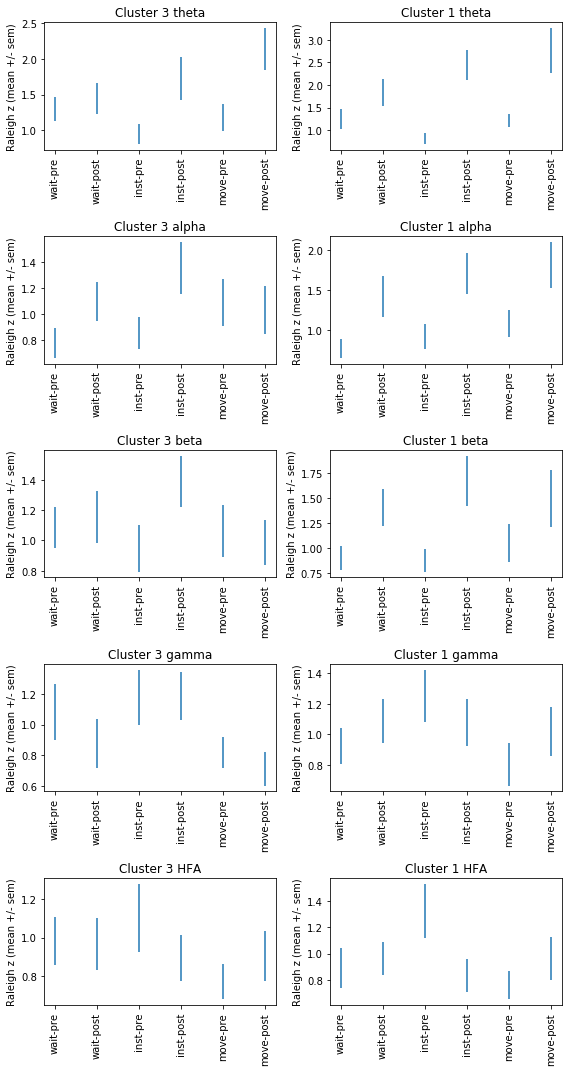

In [74]:
# plot summary of phase-reset results (mean +/- sem of z-values for theta, alpha,beta for C1 and C3)
fig = figure(figsize=[8,15])
C = get_cmap('tab10')


foi = 'theta'
ax = subplot(5,2,1)
C3.plot_errorbar_summary(ax,foi,C.colors[0])
ax = subplot(5,2,2)
C1.plot_errorbar_summary(ax,foi,C.colors[0])

foi = 'alpha'
ax = subplot(5,2,3)
C3.plot_errorbar_summary(ax,foi,C.colors[0])
ax = subplot(5,2,4)
C1.plot_errorbar_summary(ax,foi,C.colors[0])

foi = 'beta'
ax = subplot(5,2,5)
C3.plot_errorbar_summary(ax,foi,C.colors[0])
ax = subplot(5,2,6)
C1.plot_errorbar_summary(ax,foi,C.colors[0])

foi = 'gamma'
ax = subplot(5,2,7)
C3.plot_errorbar_summary(ax,foi,C.colors[0])
ax = subplot(5,2,8)
C1.plot_errorbar_summary(ax,foi,C.colors[0])

foi = 'HFA'
ax = subplot(5,2,9)
C3.plot_errorbar_summary(ax,foi,C.colors[0])
ax = subplot(5,2,10)
C1.plot_errorbar_summary(ax,foi,C.colors[0])

tight_layout()

In [142]:
# STATS
lbls_vec = [] 
p_vec=[] # for fdr correction
event_list = ['move','inst','wait']

for e in arange(0,len(event_list)):
    event_type = event_list[e]

    print('::::::::::::::::'+event_type+'::::::::::::::::::::')
    print('Cluster 3:')
    for f in arange(0,len(C3.foi_lbls)):
        lbl = 'ralz_'+event_type+'_'+C3.foi_lbls[f]+'_post'
        lbl2 = 'ralz_'+event_type+'_'+C3.foi_lbls[f]+'_pre'
        [t,p] = stats.ttest_rel(getattr(C3,lbl),getattr(C3,lbl2))
        print((C3.foi_lbls[f]+': pre vs post'),t,p)
        lbls_vec.append('C3-'+lbl+'v_pre')
        p_vec = np.append(p_vec,p)

    print('\n \nCluster 1:')
    for f in arange(0,len(C1.foi_lbls)):
        lbl = 'ralz_'+event_type+'_'+C1.foi_lbls[f]+'_post'
        lbl2 = 'ralz_'+event_type+'_'+C1.foi_lbls[f]+'_pre'
        [t,p] = stats.ttest_rel(getattr(C1,lbl),getattr(C1,lbl2))
        print((C1.foi_lbls[f]+': pre vs post'),t,p)
        lbls_vec.append('C1-'+lbl+'v_pre')
        p_vec = np.append(p_vec,p)


alfa = 0.05
[reject,p_val_corrected] = mne.stats.fdr_correction(p_vec,alfa)

idx = (p_val_corrected<=alfa).astype('bool')
print(np.array(lbls_vec)[idx])
print(p_val_corrected[idx])

::::::::::::::::move::::::::::::::::::::
Cluster 3:
theta: pre vs post 3.1978870241772905 0.0025351715568319396
alpha: pre vs post -0.20574840943124523 0.8379154252965355
beta: pre vs post -0.3362188158113117 0.738268664530567
gamma: pre vs post -0.7623134546434411 0.4498503624089851
HFA: pre vs post 0.8666346915292582 0.39073976575283387

 
Cluster 1:
theta: pre vs post 2.9878201452058146 0.004966280860797143
alpha: pre vs post 2.508629763295051 0.01663083108916856
beta: pre vs post 1.7327655732801173 0.09146625117634857
gamma: pre vs post 1.0592159675305828 0.2963675322859808
HFA: pre vs post 1.0192038320613188 0.3147245355265642
::::::::::::::::inst::::::::::::::::::::
Cluster 3:
theta: pre vs post 2.3103522860528356 0.02550971204432929
alpha: pre vs post 2.996023238938867 0.004437423772187838
beta: pre vs post 1.8393725727168537 0.07246341887227278
gamma: pre vs post 0.03706065769125142 0.9706005626095889
HFA: pre vs post -1.0015646245865173 0.3219093871796781

 
Cluster 1:
theta: 